# Libraries

In [71]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [72]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)


# Drop rows where the 'Name' column has an empty string
df = df[df['text'] != '']

df = df.drop('text_downloaded', axis=1)
df = df.drop('indexed_date', axis=1)
df = df.drop('language', axis=1)
df = df.drop('media_url', axis=1)
df = df.drop('id', axis=1)
df = df.drop('text', axis=1)
df = df.drop('publish_date', axis=1)
df = df.drop('media_name', axis=1)


df = df.reset_index(drop=True)

# df.sample(1)
df.iloc[[2]]
# df['A'] = df['A'].apply(lambda x: list(set(x)))

,title,url,year,GPE,IND,ORG
2,Why Is AI So Bad at Generating Images of Kamal...,https://www.wired.com/story/bad-kamala-harris-...,2024,"[Midjourney, Freepik]","[Elon Musk, Kamala Harris, Harris, Kamala Harr...","[X, Grok, Grok, AMERICAN, Grok, Grok, the Cent..."


## Cleaning

In [73]:
df['GPE'] = df['GPE'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
df['IND'] = df['IND'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
df['ORG'] = df['ORG'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)

for index, row in df.iterrows():

    # get rid of duplicates
           
    gpe = set(row["GPE"])
    ind = set(row["IND"])
    org = set(row["ORG"])

    ind = [a for a in ind if (" " in a)]  # remove ind without space

    df.at[index, "GPE"] = gpe
    df.at[index, "IND"] = ind
    df.at[index, "ORG"] = org

df.iloc[[2]]

,title,url,year,GPE,IND,ORG
2,Why Is AI So Bad at Generating Images of Kamal...,https://www.wired.com/story/bad-kamala-harris-...,2024,"{Midjourney, Freepik}","[Cuenca Abela, Hany Farid, Joy Boulamwini, Joe...","{AMERICAN, Modern AI, ChatGPT, the Distributed..."


## Years

In [74]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{2024, 2021, 2022, 2023}


## Entities

In [75]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"]
    ind = row["IND"]
    org = row["ORG"]
    # tag = row["TAG"]
    
    cooccurrences = list(gpe) + list(ind) + list(org)
    # cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    # for entity in tag:
    #     update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 20746


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
10,AI,org,1333,NaN,None,-1,-1,-1,"{2021: 185, 2022: 128, 2023: 579, 2024: 441}",[https://www.technologyreview.com/2024/09/10/1...,[2024 Innovator of the Year: Shawn Shan builds...,"[Midjourney, Karla Ortiz, Shawn Shan, Heather ..."


# Treatment

## Normalization

In [76]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
11606,Darren Hick,ind,1,NaN,None,-1,-1,-1,"{2021: 0, 2022: 0, 2023: 1, 2024: 0}",[https://www.theatlantic.com/ideas/archive/202...,[Here Comes the Second Year of AI College],"[Knoxville, Kelly Ahuna, Carlee Warfield, Brya...",0.0,"{""2021"": 0, ""2022"": 0, ""2023"": 1, ""2024"": 0}"


## Filter Entities

In [147]:

# counting

len_gpe = entities_all.loc[(entities_all["type"] == "gpe")].shape[0]
len_ind = entities_all.loc[(entities_all["type"] == "ind")].shape[0]
len_org = entities_all.loc[(entities_all["type"] == "org")].shape[0]
# len_tag = entities_all.loc[(entities_all["type"] == "tag")].shape[0]

print(len_gpe, len_ind, len_org)


max_gpe = 0
max_ind = 150
max_org = 50
# max_tag = 100

min_frequency = 10



top_gpe = (
    entities_all.loc[
        (entities_all["type"] == "gpe")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_gpe)
)
top_ind = (
    entities_all.loc[
        (entities_all["type"] == "ind")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_ind)
)
top_org = (
    entities_all.loc[
        (entities_all["type"] == "org")
        & (entities_all["frequency"] > min_frequency)
    ]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_org)
)
# top_tag = (
#     entities_all.loc[
#         (entities_all["type"] == "tag")
#         & (entities_all["frequency"] > min_frequency * .5)
#     ]
#     .sort_values(by=["frequency"], ascending=False)
#     # .head(max_tag)
# )

entities = pd.concat([top_gpe, top_ind, top_org])

len(entities) # 400 is a good number for the map

1538 7565 11643


133

In [148]:
entities.sample(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
665,Senate,org,78,NaN,None,-1,-1,-1,"{2021: 7, 2022: 6, 2023: 33, 2024: 32}",[https://www.theverge.com/2024/9/3/24233767/ca...,"[All the news about SB 1047, California’s bid ...","[US, California, TODAY, Jason Kwon, Scott Wien...",0.057808,"{""2021"": 7, ""2022"": 6, ""2023"": 33, ""2024"": 32}"
7313,Rumman Chowdhury,ind,11,NaN,None,-1,-1,-1,"{2021: 1, 2022: 2, 2023: 7, 2024: 1}",[https://www.technologyreview.com/2024/01/29/1...,"[Three ways we can fight deepfake porn, Americ...","[Virginia, China, New Jersey, UK, New York, US...",0.007508,"{""2021"": 1, ""2022"": 2, ""2023"": 7, ""2024"": 1}"
891,Caroline Mimbs Nyce,ind,13,NaN,None,-1,-1,-1,"{2021: 0, 2022: 0, 2023: 2, 2024: 11}",[https://www.theatlantic.com/newsletters/archi...,"[Donald Trump, AI Artist, Silicon Valley Is Co...","[Chicago, California, Trump, masse, Charlie Wa...",0.009009,"{""2021"": 0, ""2022"": 0, ""2023"": 2, ""2024"": 11}"


## Linear Regression

In [149]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
4764,Ron DeSantis,ind,13,-1.661446,None,-1,-1,-1,"{2021: 0, 2022: 1, 2023: 9, 2024: 3}",[https://www.wired.com/story/inside-the-lukewa...,[Inside the Reluctant Fight to Ban Deepfake Ad...,"[OpIndia, Florida, New York, US, Dublin, India...",0.009009,"{""2021"": 0, ""2022"": 1, ""2023"": 9, ""2024"": 3}"


## Colors

In [150]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
352,Sam Altman,ind,256,29.638554,#b40426,-1,-1,-1,"{2021: 15, 2022: 21, 2023: 132, 2024: 88}",[https://www.wired.com/story/deepfake-porn-ele...,"[Could AI and Deepfakes Sway the US Election?,...","[Tori, Michigan, Swifties, Massachusetts, New ...",0.191441,"{""2021"": 15, ""2022"": 21, ""2023"": 132, ""2024"": 88}"


# Embedding

## Term Frequency

In [151]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


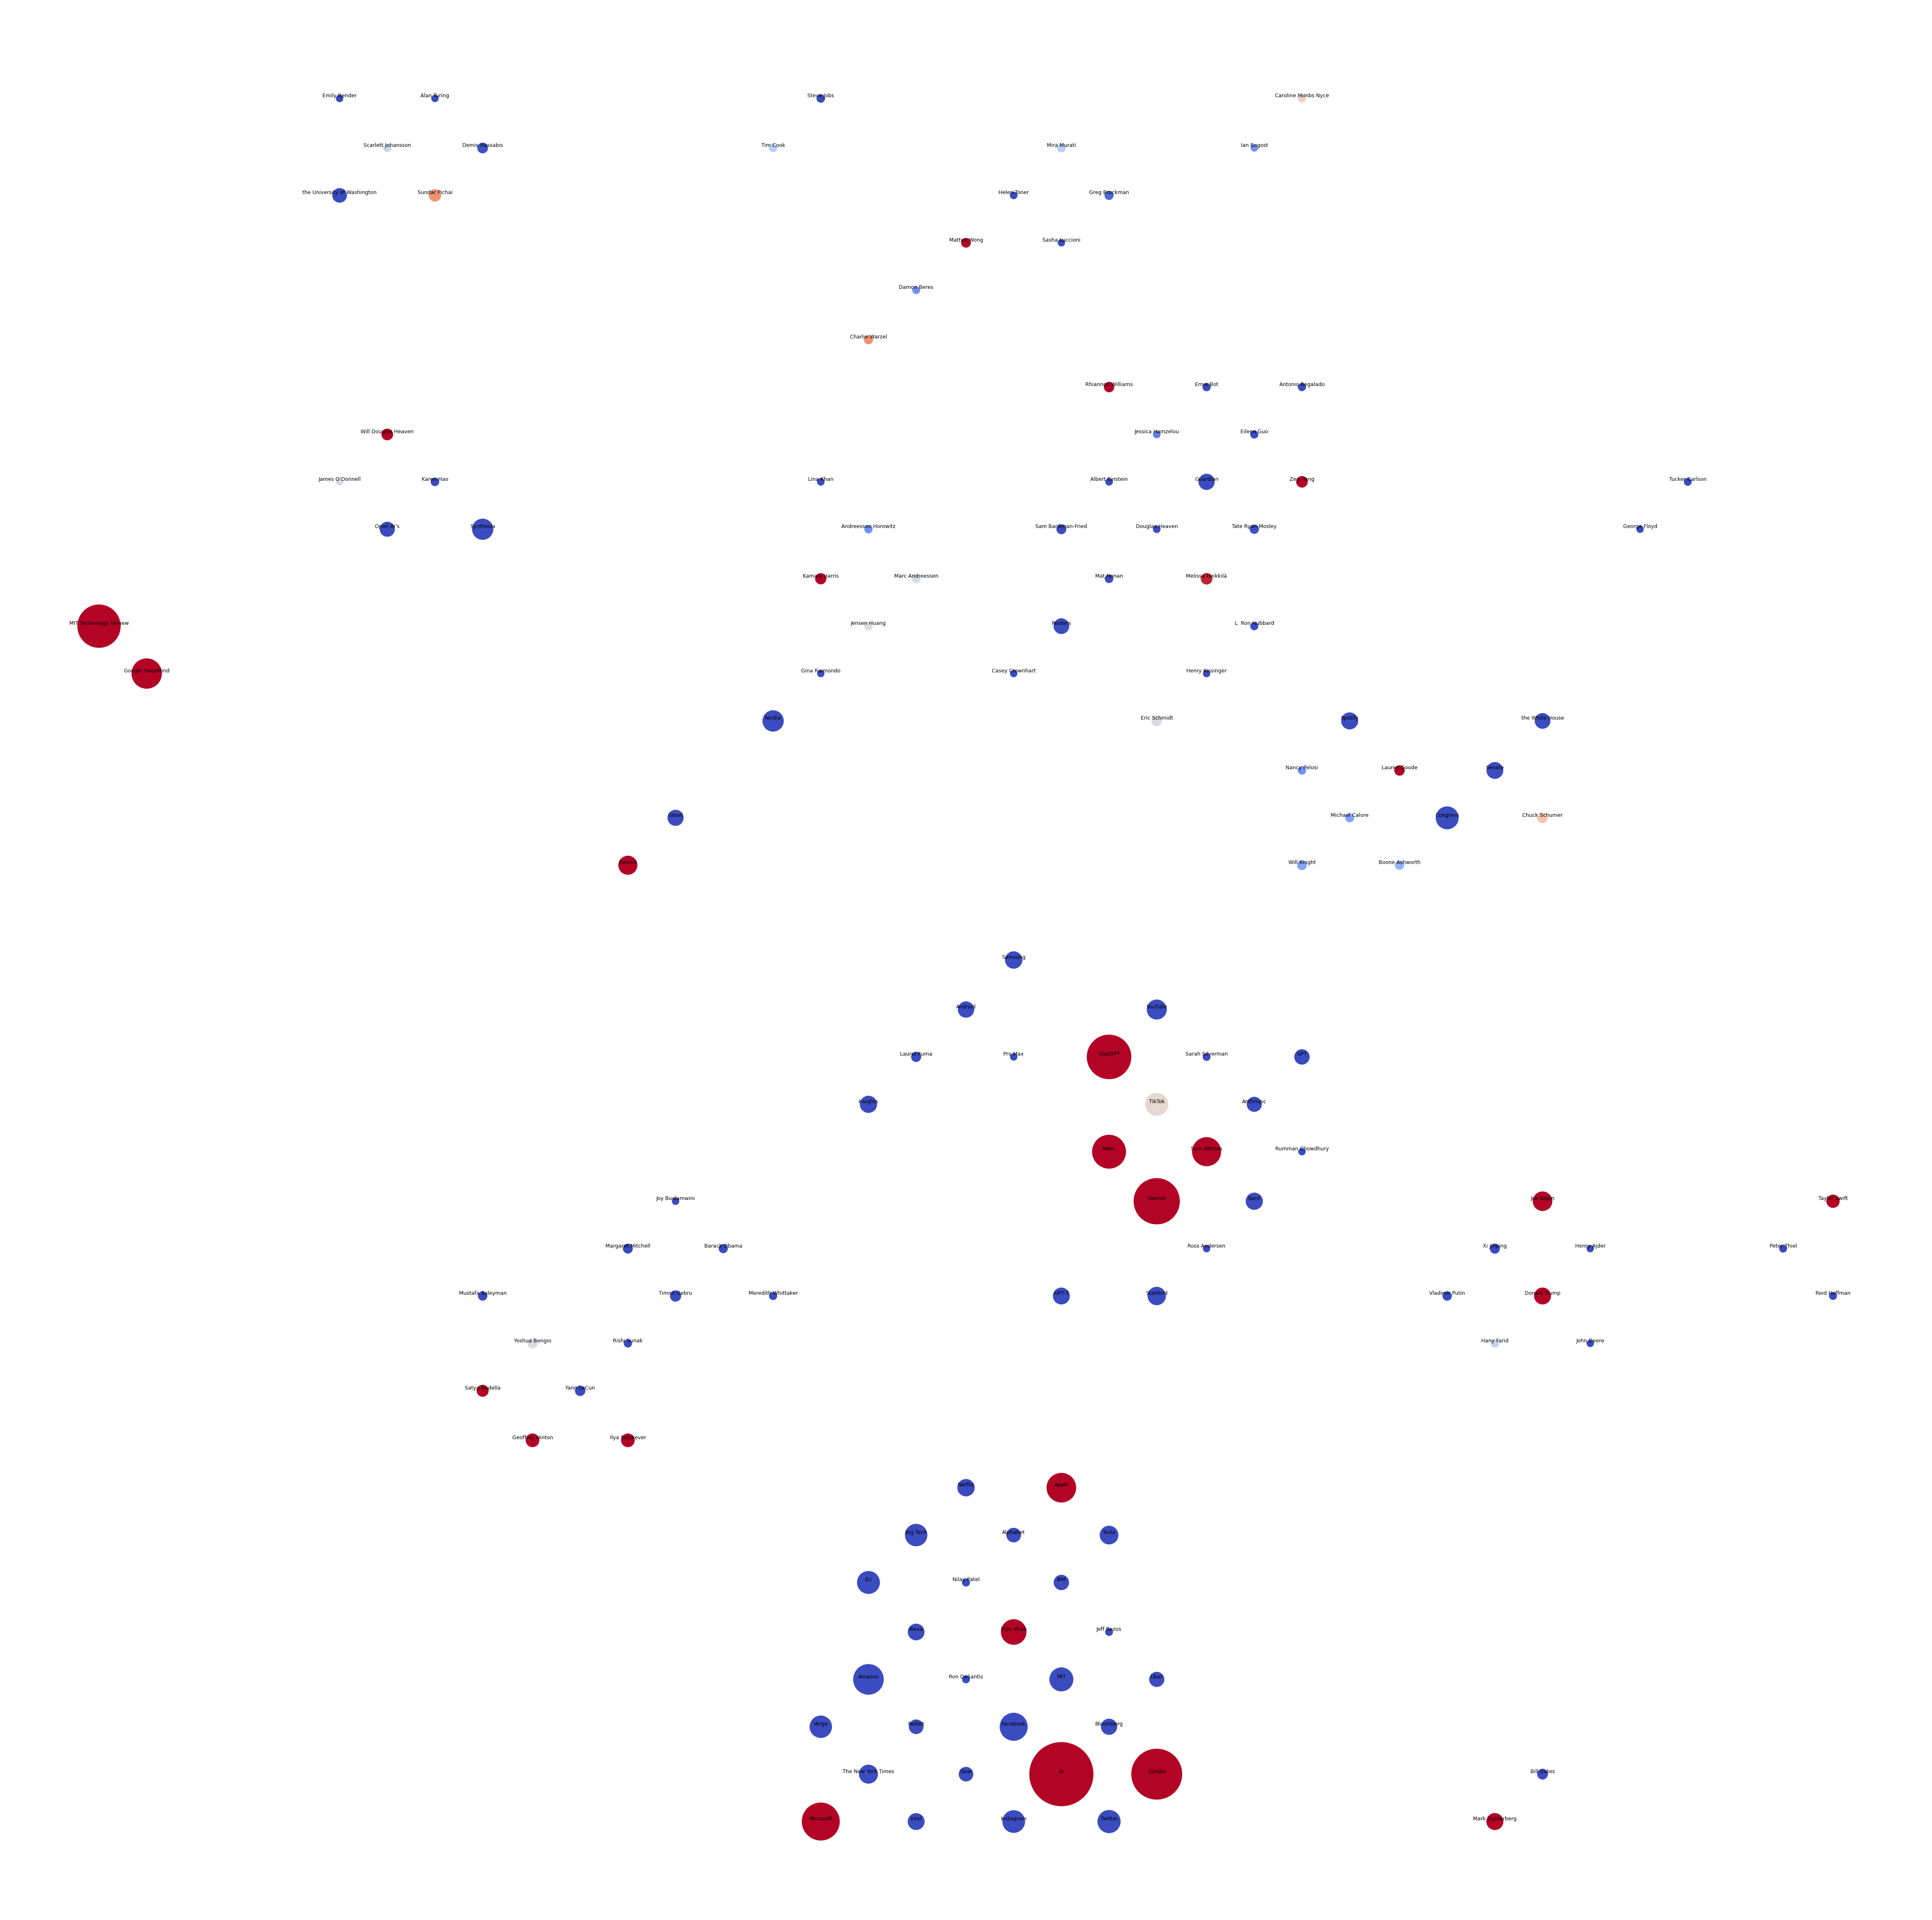

In [152]:
reducer = umap.UMAP(
    random_state=5,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [153]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "tag") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
352,Sam Altman,ind,256,29.638554,#b40426,611,411,p_1,"{2021: 15, 2022: 21, 2023: 132, 2024: 88}",[https://www.wired.com/story/deepfake-porn-ele...,"[Could AI and Deepfakes Sway the US Election?,...","[Tori, Michigan, Swifties, Massachusetts, New ...",0.191441,"{""2021"": 15, ""2022"": 21, ""2023"": 132, ""2024"": 88}"


{'n_3', 'n_8', 'n_1', 'n_9', 'n_0', 'p_0', 'n_5', 'n_4', '-1', 'n_2', 'n_7', 'p_1', 'n_6'}
9
12
4
7
5
9
5
5
30
23
8
12
4


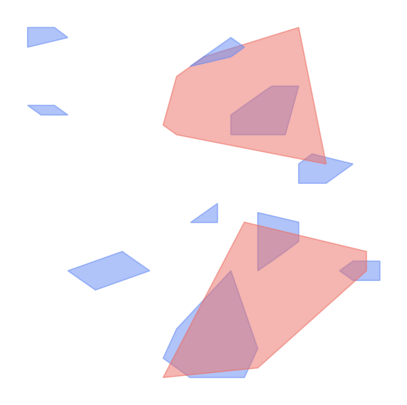

In [154]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [155]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
586,Vladimir Putin,ind,20,-1.161446,#3b4cc0,722,344,n_5,[https://www.theatlantic.com/politics/archive/...,0.014264,"{""2021"": 1, ""2022"": 4, ""2023"": 8, ""2024"": 7}"
